[Slicematrix](https://slicematrix.github.io/stock_market_anomalies.html)

In [28]:
from slicematrixIO import SliceMatrix

In [29]:
#from slicematrixIO.connect import ConnectIO


In [30]:
# create slicematrix account to get your API key, confirmation e-mail took hours
# pip install slicematrixIO
# slicematrixIO only runs on Python 2 as of July 2017
from slicematrixIO import SliceMatrix

api_key = "oABo7H3NCD37pTlIfcXKS2u7LDtmLjLp7TFlaFnK"
sm = SliceMatrix(api_key)

In [31]:
%matplotlib inline
import pandas as pd
#import pandas.io.data as web
#from pandas_datareader import data as web
import pandas_datareader as pdr
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

Grab trading volume data from Yahoo for our list of stocks using Pandas' Data-Reader

In [32]:
apple = pdr.get_data_yahoo('AAPL')
type(apple)

pandas.core.frame.DataFrame

In [33]:
# There might be some data download limit when we try the whole list
symbols = ['SPY', 'IWM', 'DIA', 'IEF', 'TLT']
#symbols = ['GLD', 'SLV', 'USO', 'XIV']
#symbols = ['AAPL']
#symbols = ['TLT']

start = dt.datetime(2012, 1, 1)
end = dt.datetime(2017, 3, 6)

volume = []
closes = []
for symbol in symbols:
    print( symbol)
    vdata = pdr.get_data_yahoo(symbol, start, end)
    cdata = vdata[['Close']]
    closes.append(cdata)
    vdata = vdata[['Volume']]
    volume.append(vdata)
    

SPY
IWM
DIA
IEF
TLT


In [34]:
volume = pd.concat(volume, axis = 1).dropna()
volume.columns = symbols
closes = pd.concat(closes, axis = 1).dropna()
closes.columns = symbols

In [35]:
volume.head()

,SPY,IWM,DIA,IEF,TLT
Date,,,,,
2012-01-03,193697900,60504700,7175100,1297700,9076900
2012-01-04,127186500,34648500,7625200,1789000,8417100
2012-01-05,173895000,57274600,8678900,1311300,6465800
2012-01-06,148050000,45499800,7488600,998200,7348500
2012-01-09,99530200,52042400,5881800,379900,5582400


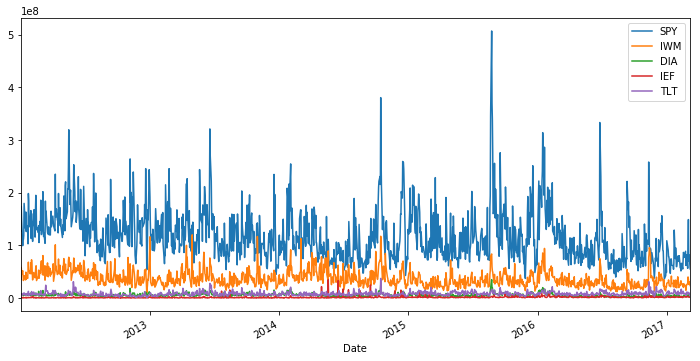

In [36]:
volume.plot(figsize=(12, 6))
plt.show()

In [37]:
# isolation forest multivariate anomaly detector
iso_forest1 = sm.IsolationForest(dataset = volume, rate = 0.1)  # want signal every 1 / 10 days on average
iso_forest2 = sm.IsolationForest(dataset = volume, rate = 0.2)  # want signal every 1 / 5 days on average
iso_forest3 = sm.IsolationForest(dataset = volume, rate = 0.33) # want signal every 1 / 3 days on average

In [38]:
scores1 = iso_forest1.training_scores()
scores2 = iso_forest2.training_scores()
scores3 = iso_forest3.training_scores()
scores1 = pd.DataFrame(scores1, columns = ["scores"])
scores2 = pd.DataFrame(scores2, columns = ["scores"])
scores3 = pd.DataFrame(scores3, columns = ["scores"])

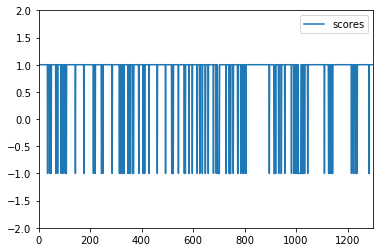

In [39]:
scores1.plot(ylim = (-2.0, 2.0))

In [40]:
print scores1.shape, volume.shape

(1301, 1) (1301, 5)


In [41]:
import matplotlib.collections as collections

In [42]:
def draw_anomaly_plot(scores, volume, title, lw = 2):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(title)

    ax.plot(scores.index.values, volume.sum(axis = 1), color='black')
    ax.axhline(0, color='black', lw=2)

    for i in range(0, scores.shape[0]):
        score = scores.ix[i]
        if score[0] < 0:
            l = plt.axvline(x=i, color='red', alpha=0.25, lw = lw)

    plt.show()

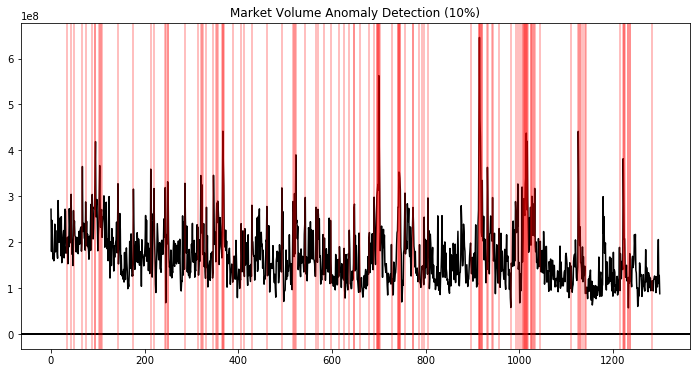

In [43]:
draw_anomaly_plot(scores1, volume, 'Market Volume Anomaly Detection (10%)')

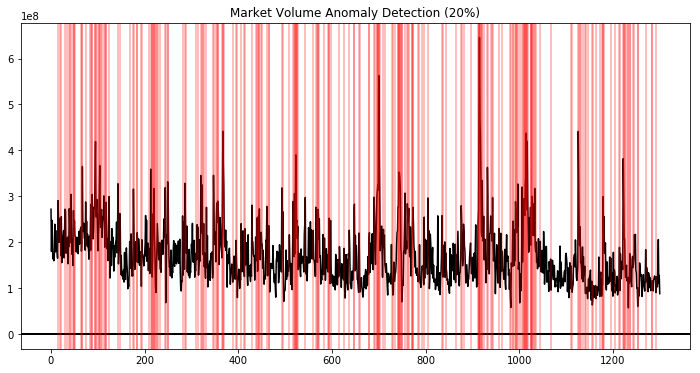

In [44]:
draw_anomaly_plot(scores2, volume, 'Market Volume Anomaly Detection (20%)')

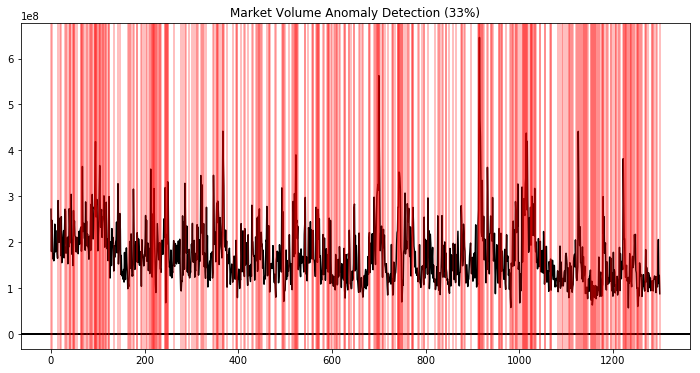

In [45]:
draw_anomaly_plot(scores3, volume, 'Market Volume Anomaly Detection (33%)')

In [46]:
# split the dataset
volume_training = volume.ix[0:1200,:]
volume_testing  = volume.ix[1201:,:]

In [47]:
iso_forest_live_model = sm.IsolationForest(dataset = volume_training, rate = 0.2)

In [48]:
out_of_sample_scores  = iso_forest_live_model.score(volume_testing.values.tolist())

In [49]:
out_of_sample_scores  = pd.DataFrame(out_of_sample_scores, columns = ['scores'])
out_of_sample_scores.tail()

,scores
95,1
96,1
97,1
98,1
99,1


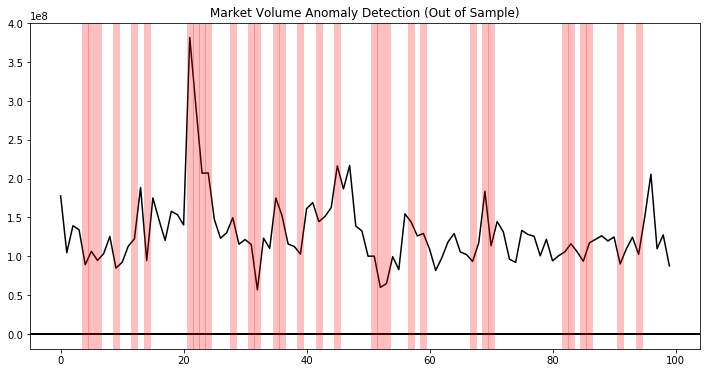

In [50]:
draw_anomaly_plot(out_of_sample_scores, volume_testing, 'Market Volume Anomaly Detection (Out of Sample)', lw = 7)

In [51]:
# You will need to insert the model name in the line below
# each time you run these cells
print iso_forest_live_model.name

365d5a424339


In [52]:
# in another process
iso_forest_live_model = sm.IsolationForest(name = "365d5a424339") #insert model name (number)

In [ ]:
# not working yet
# when we get a new data point we want to score...

iso_forest_live_model.score([[66650800, 30445200, 2580800, 2469300, 9460700, 10536000, 8681600, 13807500, 8518800]])